In [1]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import pandas as pd
from model import Company, StockLog, PerformanceLog
from model import start_engine

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
engine = start_engine()

In [6]:
company = Company().query().get('ABC')

In [7]:
stock_logs = StockLog().query().filter(StockLog.company==company).order_by(StockLog.date)

In [8]:
df = pd.read_sql(stock_logs.statement, engine)

In [9]:
df.head()

date code  opening  high   low  closing  adjusted  volume prediction  \
0  2000-01-03  ABC     0.71  0.71  0.68     0.68      0.28  121466       None   
1  2000-01-04  ABC     0.68  0.70  0.68     0.70      0.29  150276       None   
2  2000-01-05  ABC     0.68  0.69  0.67     0.68      0.28  303203       None   
3  2000-01-06  ABC     0.68  0.68  0.67     0.67      0.27  358754       None   
4  2000-01-09  ABC     0.66  0.67  0.66     0.67      0.27  265345       None   

    sma   ema   per  rank   cap  
0  None  None  None  None  None  
1  None  None  None  None  None  
2  None  None  None  None  None  
3  None  None  None  None  None  
4  None  None  None  None  None

In [10]:
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

In [11]:
for i in range(0, len(df)):
    new_data['Date'][i] = df['date'][i]
    new_data['Close'][i] = df['closing'][i]

In [12]:
new_data.index = new_data.Date

In [13]:
new_data.drop('Date', axis=1, inplace=True)

In [14]:
dataset = new_data.values

In [15]:
train = dataset[0:4000,:]
valid = dataset[4000:,:]

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [17]:
x_train, y_train = [], []

In [18]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [20]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 633s - loss: 5.0764e-04


In [22]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [23]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [24]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [25]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.11147733854663472

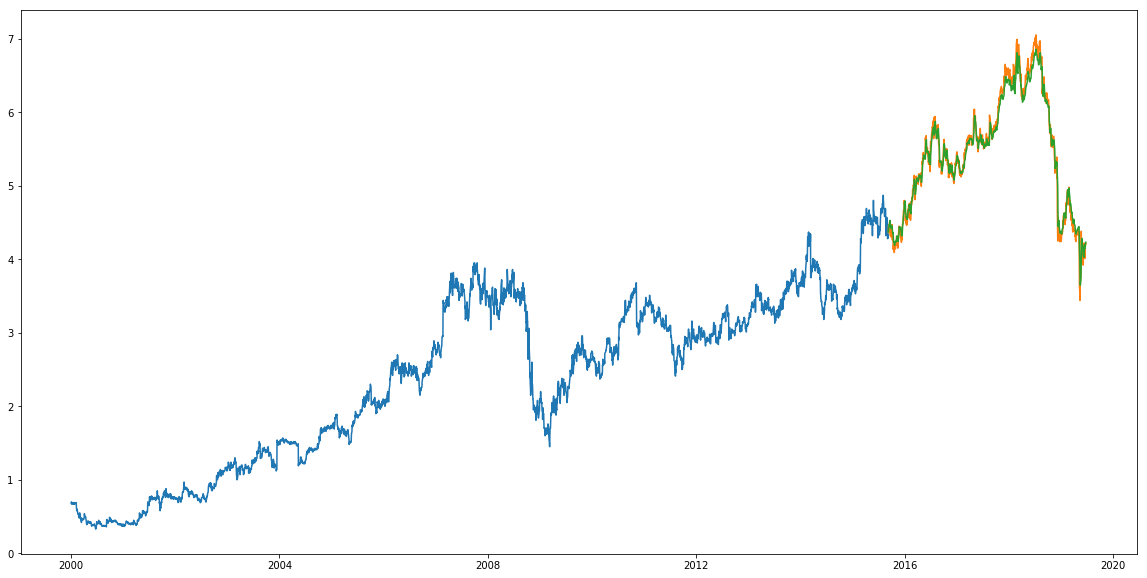

In [26]:
train = new_data[:4000]
valid = new_data[4000:]
valid['Predictions'] = closing_price
plt.figure(figsize=(20,10)) 
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

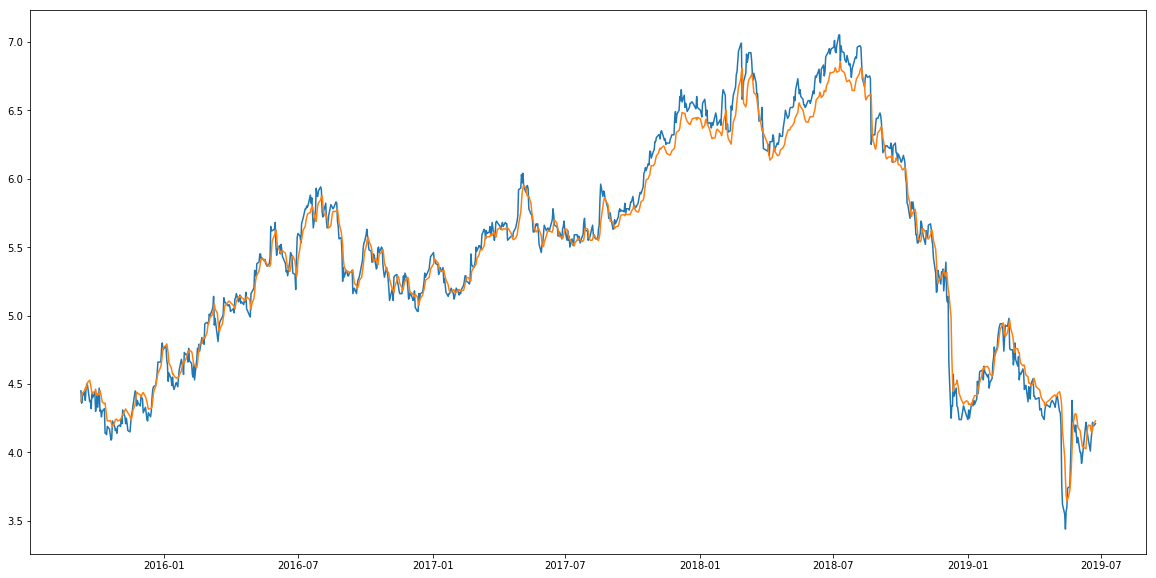

In [28]:
plt.figure(figsize=(20,10)) 
plt.plot(valid[['Close', 'Predictions']])

In [32]:
perf_logs = PerformanceLog().query().filter(PerformanceLog.company==company).order_by(PerformanceLog.date)

In [35]:
df2 = pd.read_sql(perf_logs.statement, engine)

In [37]:
df2.head()

date code       revenue     expenses       ebitda         ebit  \
0  2009-12-31  ABC  1.009700e+09 -767600000.0  242100000.0  185300000.0   
1  2010-12-31  ABC  1.079100e+09 -810100000.0  269000000.0  216200000.0   
2  2011-12-31  ABC  1.110400e+09 -829200000.0  281200000.0  223400000.0   
3  2012-12-31  ABC  1.183400e+09 -892600000.0  290800000.0  225600000.0   
4  2013-12-31  ABC  1.230900e+09 -937600000.0  293300000.0  222700000.0   

        profit       npataa        assets  liabilities  ...  \
0  168600000.0  123200000.0  1.355000e+09  458000000.0  ...   
1  202200000.0  151400000.0  1.331900e+09  397600000.0  ...   
2  206400000.0  148400000.0  1.466200e+09  509100000.0  ...   
3  209200000.0  154100000.0  1.616700e+09  608600000.0  ...   
4  208600000.0  151100000.0  1.633700e+09  571900000.0  ...   

   non_interest_expense  interest_margin  spread  non_interest_total  \
0                  None             None    None                None   
1                  None             None    None                None   
2                  None             None    None                None   
3                  None             None    None                None   
4                  None             None    None                None   

   abnormals  pretax_profit  claims_ratio  expense_ratio  profitability  \
0        0.0    168600000.0          None           None           None   
1        0.0    202200000.0          None           None           None   
2        0.0    206400000.0          None           None           None   
3        0.0    209200000.0          None           None           None   
4        0.0    208600000.0          None           None           None   

   solvency  
0      None  
1      None  
2      None  
3      None  
4      None  

[5 rows x 91 columns]